In [1]:
!pip install networkx yfinance

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 9.8 MB/s eta 0:00:00ta 0:00:01
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)
  Created wheel for peewee: filename=peewee-3.18.1-cp311-cp311-macosx_10_13_x86_64.whl size=274318 sha256=0ad30326c6e4e91d1345c7f72c1ff82a2961897004fea5f841186d69cb6bdfbb
  Stored in directory: /Users/macbookair/Library/Caches/pip/wheels/25/cb/79/a133a0d1d75f318a96614ed7fb97bdf2f35a7b6c4d4e426e3f
Successfully built peewee
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [23]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import GraphicalLasso
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import yfinance as yf
import warnings

In [3]:
assets=['AAPL', 'WMT', 'AMZN', 'GE', 'GOOGL',  'JPM', 'WBD']
factors=['^GSPC', 'XLF', 'XLK', 'SHY', 'DX-Y.NYB'] #SP500, Fin Sector SPDR, Tech Sector SPDR, Short Term Treasury ETF, USD Index

tickers = assets+ factors

data=yf.download(tickers, start='2018-01-01', end='2024-12-31', auto_adjust=False)['Adj Close']

returns= data.pct_change().dropna()

returns.columns=['Apple', 'Amazon', 'USD', 'GE', 'Google', 'JPMorgan', 'Treasury', 'Warner-Bro', 'Walmart', 'Financial', 'Technology', 'SP500']

[*********************100%***********************]  12 of 12 completed


In [4]:
returns

,Apple,Amazon,USD,GE,Google,JPMorgan,Treasury,Warner-Bro,Walmart,Financial,Technology,SP500
Date,,,,,,,,,,,,
2018-01-03,-0.000174,0.012775,0.003375,0.009455,0.017061,0.001019,0.000000,-0.021203,0.008723,0.005372,0.008341,0.006399
2018-01-04,0.004645,0.004476,-0.003364,0.020937,0.003884,0.014326,-0.000477,-0.021662,0.000905,0.009263,0.005055,0.004029
2018-01-05,0.011385,0.016163,0.001089,0.000540,0.013260,-0.006420,0.000000,-0.005874,0.005927,0.002824,0.010517,0.007034
2018-01-08,-0.003714,0.014425,0.004133,-0.014024,0.003531,0.001477,0.000000,0.016818,0.014781,-0.001408,0.003771,0.001662
2018-01-09,-0.000115,0.004676,0.002166,0.015317,-0.001274,0.005069,-0.000358,-0.032186,-0.012007,0.007755,-0.002555,0.001303
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.003065,0.000622,0.003903,0.003861,0.016823,0.003325,-0.000611,-0.023386,-0.020490,0.002401,0.010595,0.007287
2024-12-24,0.011478,0.017729,0.002036,0.014614,0.007604,0.016444,0.000489,0.010536,0.025789,0.011772,0.010333,0.011043
2024-12-26,0.003176,-0.008732,-0.001201,0.003849,-0.002601,0.003425,0.000245,0.006635,0.001187,0.002449,0.000665,-0.000406


## Linear Regression

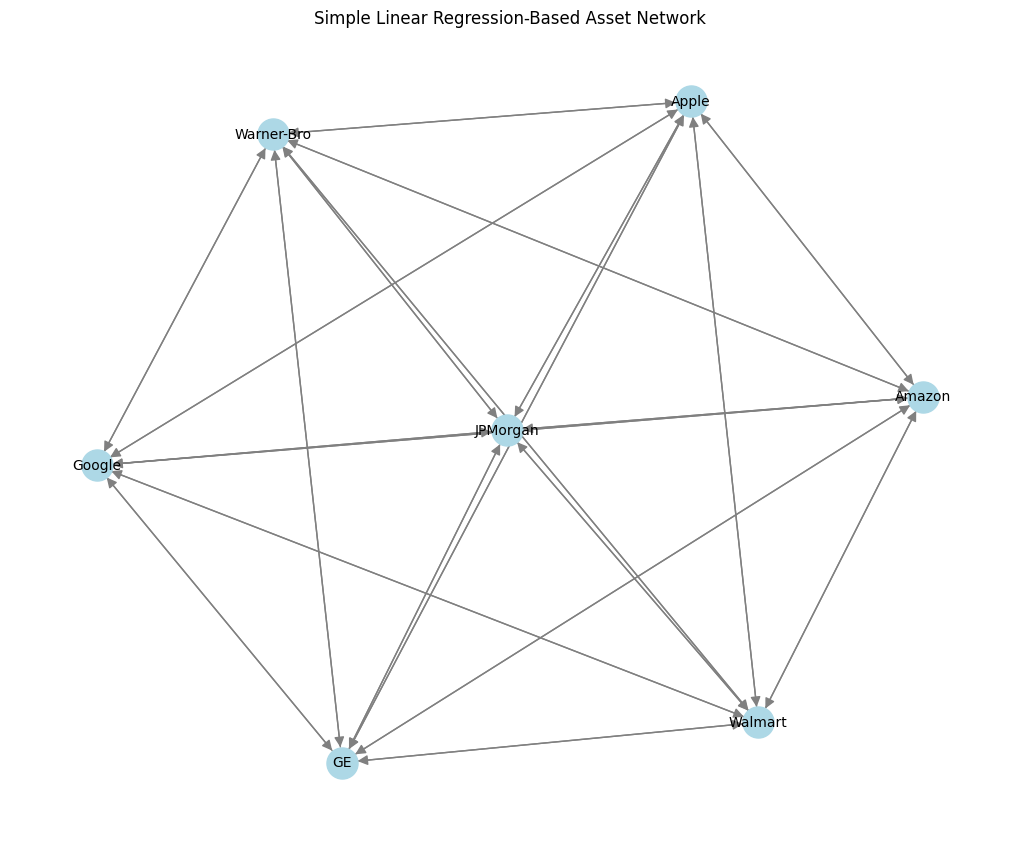

In [5]:
assets = returns[["Apple","Amazon","GE", "Google","JPMorgan","Warner-Bro","Walmart"]]

n_assets = len(assets.columns)
adj_matrix = np.zeros((n_assets, n_assets))

#Significane level based on Bonferrini : 
p_threshold = 0.05/(n_assets*(n_assets-1))

#Loop Through all pairs
for i, asset_i in enumerate(assets):
    for j, asset_j in enumerate(assets):
        if i !=j : 
            model = sm.OLS(assets[asset_i], sm.add_constant(assets[asset_j])).fit()
            p_value = model.pvalues.iloc[1]

            adj_matrix[i,j] = 1 if p_value<p_threshold else 0

#Create directed graph : 
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

#Label nodes with assets names
mapping = {i: name for i, name in enumerate(assets)}
G = nx.relabel_nodes(G, mapping)

#Plot the network : 
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, 
        node_color='lightblue',
        node_size=500,
        with_labels=True,
        font_size=10,
        edge_color='gray',
        arrows=True,
        arrowsize=15)

plt.title('Simple Linear Regression-Based Asset Network')
plt.show()

In [6]:
adj_matrix

array([[0., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 0.]])

## Non-linear regression

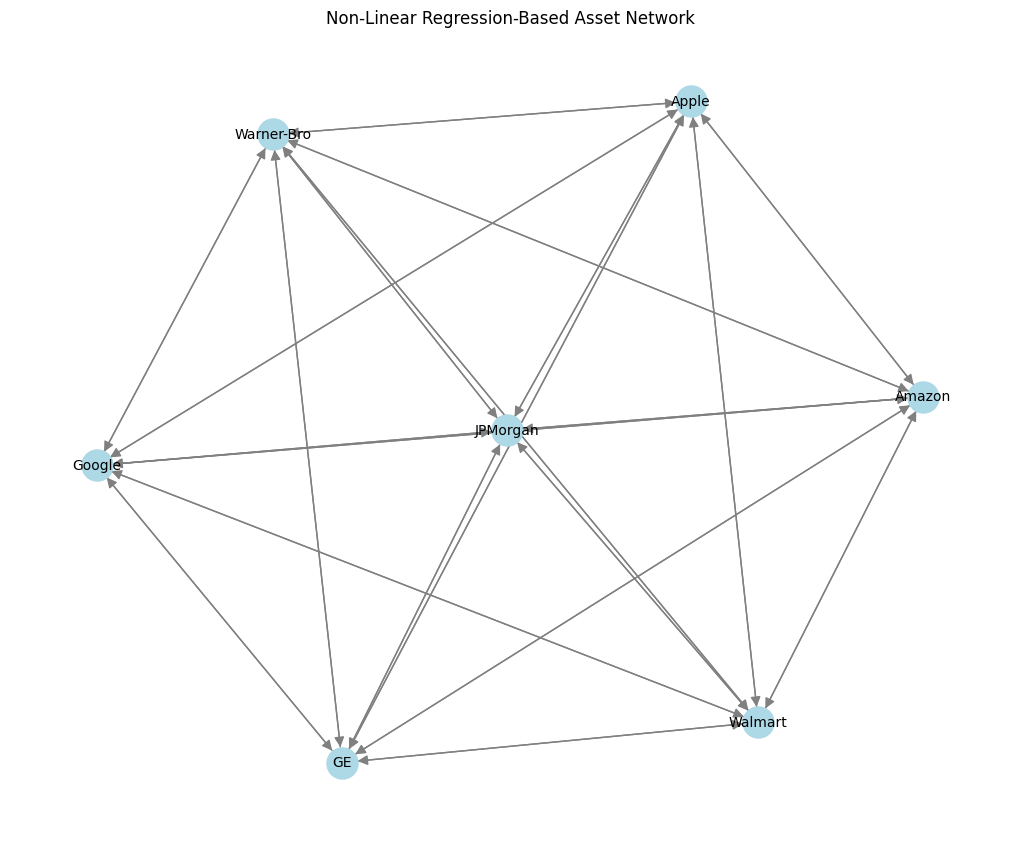

In [ ]:

n_assets = len(assets.columns)
adj_matrix = np.zeros((n_assets, n_assets))
p_threshold = 0.05/(n_assets*(n_assets-1))

for i, asset_i in enumerate(assets):
    for j, asset_j in enumerate(assets):
        if i!=j : 
            indep= pd.concat([assets[asset_j], assets[asset_j]**2],axis=1)
            X = sm.add_constant(indep)
            model= sm.OLS(assets[asset_i], X).fit()

            p_value = model.pvalues.iloc[1]

            adj_matrix[i,j] = 1 if p_value<p_threshold else 0

G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
mapping = {i: name for i, name in enumerate(assets)}
G = nx.relabel_nodes(G, mapping)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos,
        node_color='lightblue',
        node_size=500,
        with_labels=True,
        font_size=10,
        edge_color='gray',
        arrows=True,
        arrowsize=15)
plt.title('Non-Linear Regression-Based Asset Network')
plt.show()

In [8]:
adj_matrix

array([[0., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 0.]])

## Linear Regression with Confounder Variable

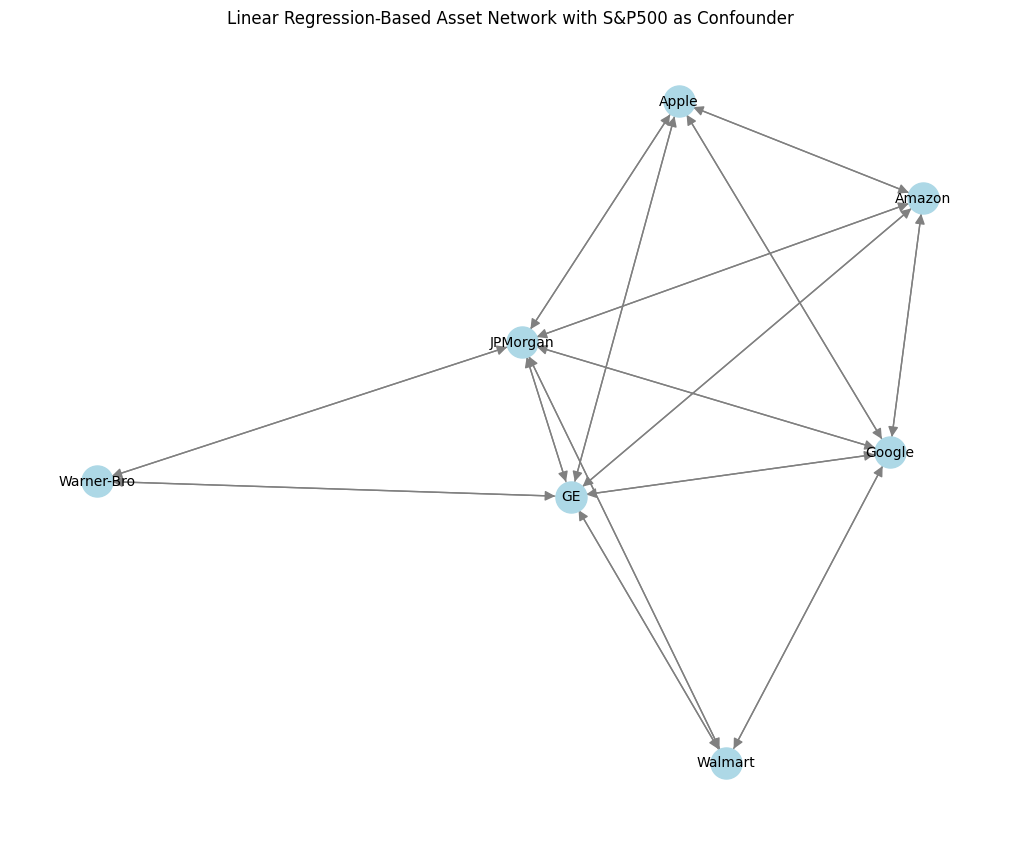

In [11]:
n_assets = len(assets.columns)
adj_matrix = np.zeros((n_assets, n_assets))
SP500 = returns["SP500"]
p_threshold = 0.05/(n_assets*(n_assets-1))

for i, asset_i in enumerate(assets):
    for j, asset_j in enumerate(assets):
        if i!=j:
            indep = pd.concat([assets[asset_j], SP500], axis=1)
            X = sm.add_constant(indep)
            model = sm.OLS(assets[asset_i], X).fit()
            p_value = model.pvalues.iloc[1]

            adj_matrix[i,j]= 1 if p_value<p_threshold else 0

G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Relabel nodes with asset names
mapping = {i: name for i, name in enumerate(assets)}
G = nx.relabel_nodes(G, mapping)

# Create and visualize the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos,
        node_color='lightblue',
        node_size=500,
        with_labels=True,
        font_size=10,
        edge_color='gray',
        arrows=True,
        arrowsize=15)
plt.title('Linear Regression-Based Asset Network with S&P500 as Confounder')
plt.show()

## Graphical LASSO

In [12]:
standardized_returns = (returns- returns.mean())/returns.std()

In [13]:
rhos = np.linspace(0.3,1,100)
model_cv = GraphicalLassoCV(alphas=rhos, cv=5, tol=1e-2, max_iter=400)
model_cv.fit(standardized_returns)

best_rho = model_cv.alpha_
print(f'Best rho : {best_rho}')

Best rho : 0.3


In [14]:
model=GraphicalLasso(alpha=best_rho, max_iter=400, tol=1e-2)
model.fit(standardized_returns)

#Get precision matrix
precision_matrix = model.precision_

#Convert to partial correlation matrix 
d = np.sqrt(np.diag(precision_matrix))
partial_corr= -precision_matrix/np.outer(d,d)
np.fill_diagonal(partial_corr,0) #remove self loops
partial_corr



array([[ 0.        ,  0.05949545, -0.        ,  0.        ,  0.06795799,
         0.        , -0.        ,  0.        ,  0.        ,  0.        ,
         0.32167022,  0.1546649 ],
       [ 0.05949545,  0.        , -0.        ,  0.        ,  0.17875541,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.16728493,  0.0826592 ],
       [-0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.04547533, -0.        , -0.        , -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
         0.0699315 , -0.        ,  0.        ,  0.        ,  0.14693524,
         0.        ,  0.07788539],
       [ 0.06795799,  0.17875541, -0.        ,  0.        ,  0.        ,
         0.        , -0.        ,  0.        ,  0.        ,  0.        ,
         0.17445875,  0.16837088],
       [ 0.        ,  0.        , -0.        ,  0.0699315 ,  0.        ,
         0.        , -

In [16]:
#Create adjacency matrix : if Ai,j >0 : 1
threshold= 0.0
adjacency = (np.abs(partial_corr)>threshold).astype(int)
adjacency

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]])

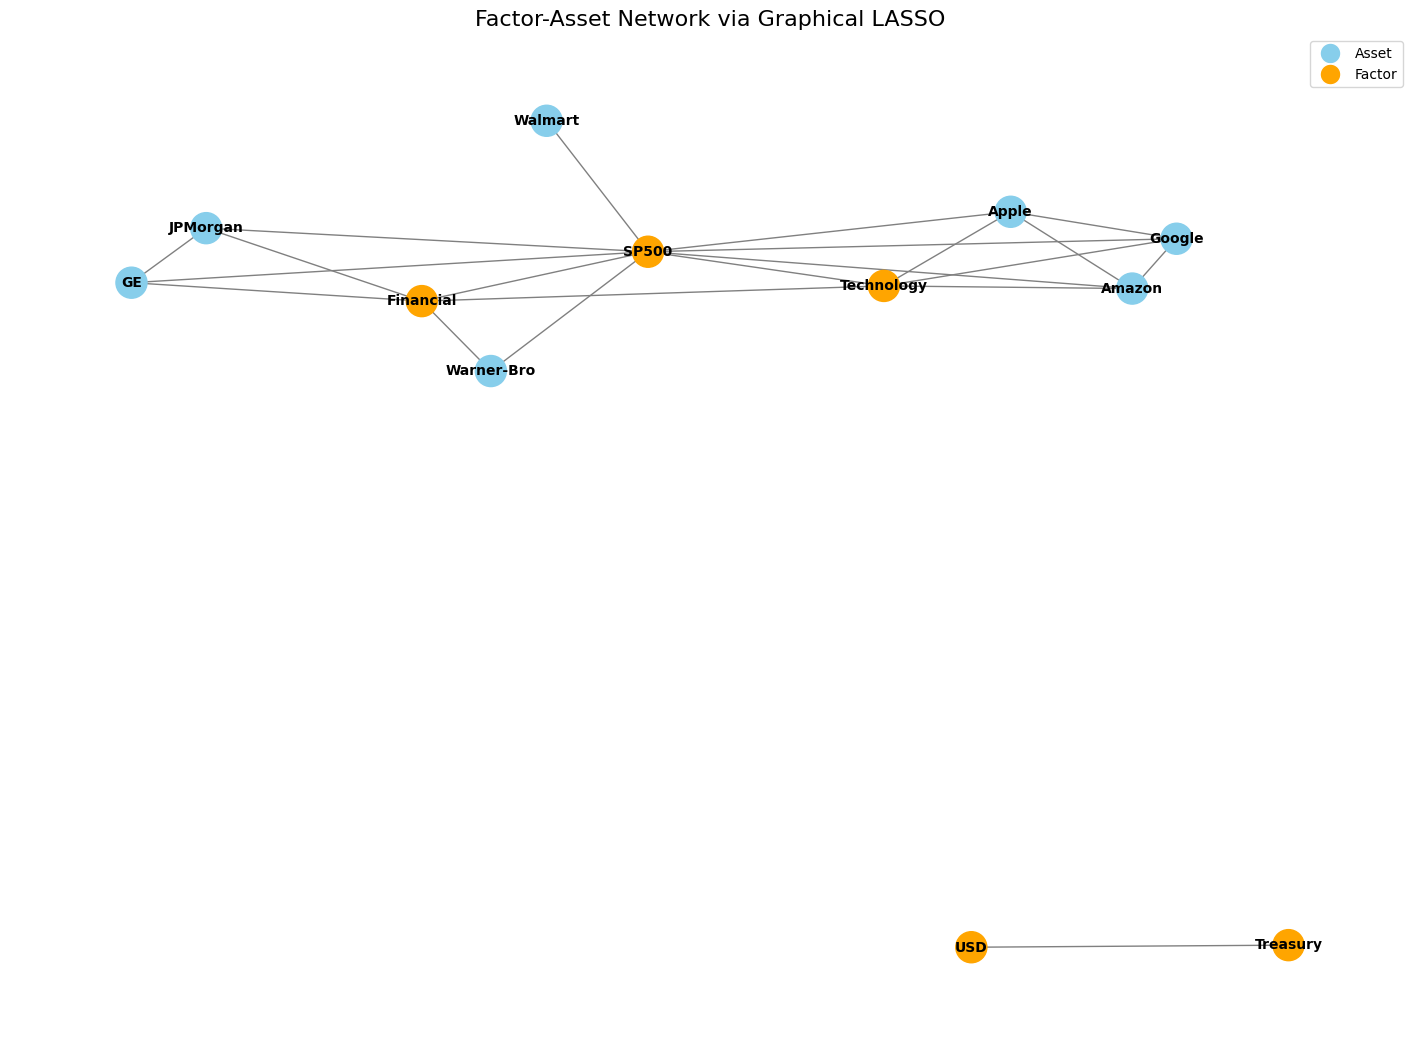

In [19]:
G = nx.from_numpy_array(adjacency)
mapping = {i:name for i, name in enumerate(returns.columns)}
G = nx.relabel_nodes(G, mapping)
node_types = {
    'Apple':'Asset',
    'Amazon':'Asset',
    'USD':'Factor',
    'GE':'Asset',
    'Google':'Asset',
    'JPMorgan':'Asset',
    'Treasury':'Factor',
    'Warner-Bro':'Asset',
    'Walmart':'Asset',
    'Financial':'Factor',
    'Technology':'Factor',
    'SP500':'Factor',
}
nx.set_node_attributes(G, node_types, 'type')

#Draw network graph : 
plt.figure(figsize=(14,10))

#Diff color for assets and factors
node_colors = ['skyblue' if G.nodes[name]['type'] == 'Asset' else 'orange' for name in G.nodes()]

pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos,
        with_labels=True,
        node_size=500,
        node_color=node_colors,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        arrows=True,
        arrowsize=15)

# Add a legend
asset_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue',
                       markersize=15, label='Asset')
factor_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange',
                        markersize=15, label='Factor')
plt.legend(handles=[asset_patch, factor_patch], loc='upper right')

plt.title('Factor-Asset Network via Graphical LASSO', fontsize=16)
plt.show()

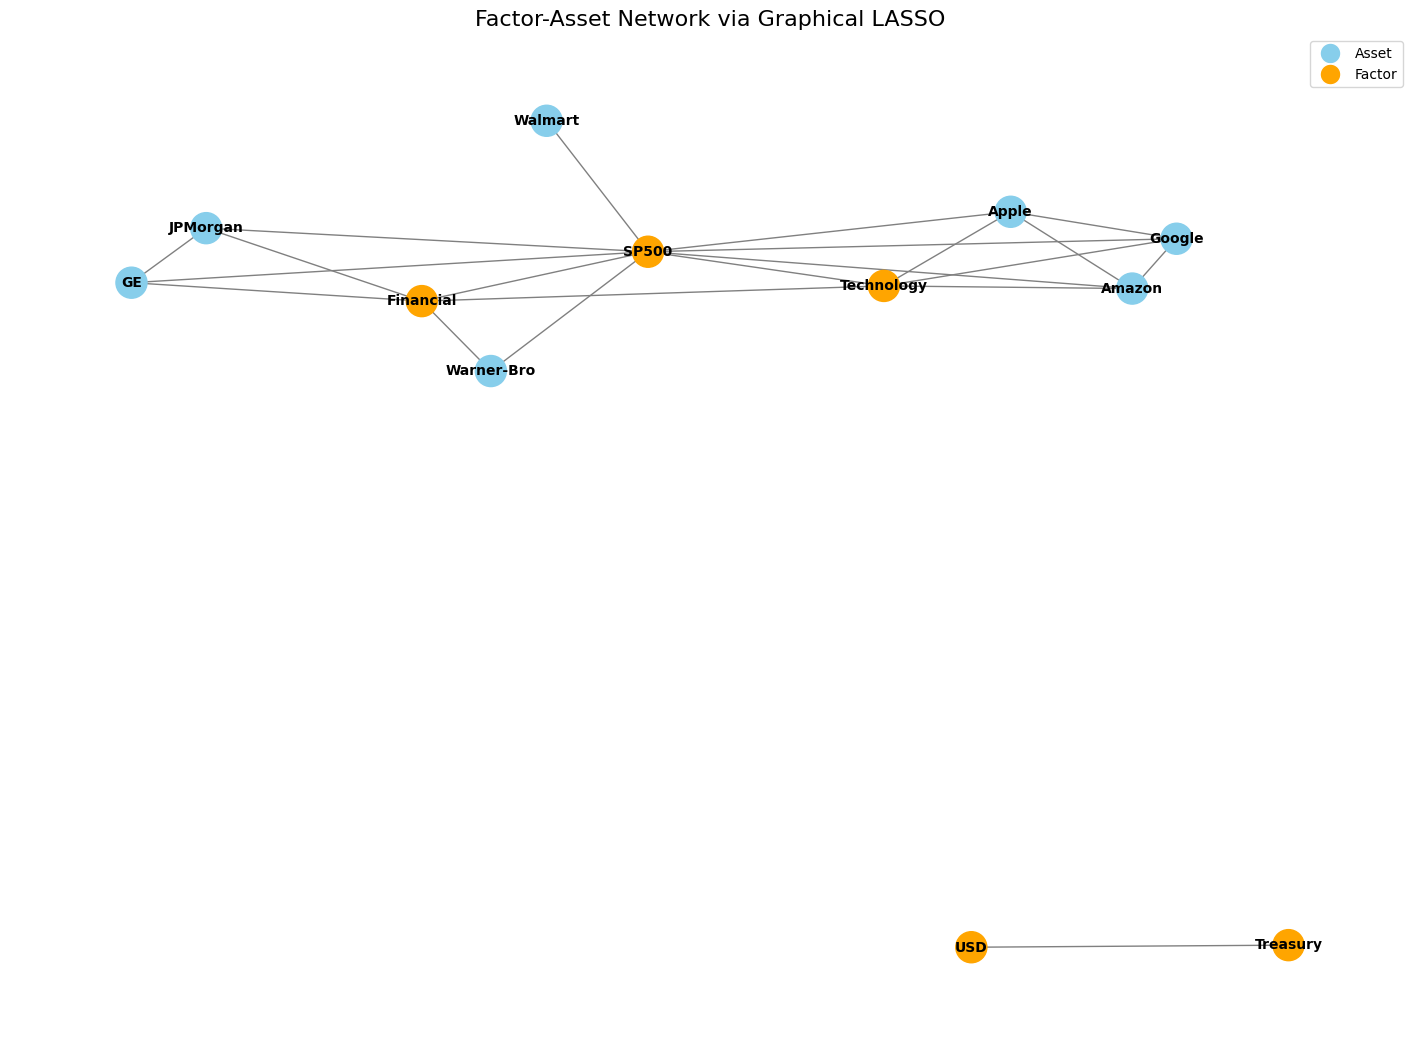

In [ ]:
# Create network
G = nx.from_numpy_array(adjacency)

mapping = {i: name for i, name in enumerate(returns.columns)}
G = nx.relabel_nodes(G, mapping)
node_types = {
    'Apple':'Asset',
    'Amazon':'Asset',
    'USD':'Factor',
    'GE':'Asset',
    'Google':'Asset',
    'JPMorgan':'Asset',
    'Treasury':'Factor',
    'Warner-Bro':'Asset',
    'Walmart':'Asset',
    'Financial':'Factor',
    'Technology':'Factor',
    'SP500':'Factor',
}

nx.set_node_attributes(G, node_types, 'type')

# Draw the network graph
plt.figure(figsize=(14, 10))

# Use different colors for assets and factors
node_colors = ['skyblue' if G.nodes[name]['type'] == 'Asset' else 'orange' for name in G.nodes()]

# Create layout
pos = nx.spring_layout(G, seed=42)

# Draw the network
nx.draw(G, pos,
        with_labels=True,
        node_size=500,
        node_color=node_colors,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        arrows=True,
        arrowsize=15)

# Add a legend
asset_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue',
                       markersize=15, label='Asset')
factor_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange',
                        markersize=15, label='Factor')
plt.legend(handles=[asset_patch, factor_patch], loc='upper right')

plt.title('Factor-Asset Network via Graphical LASSO', fontsize=16)
plt.show()

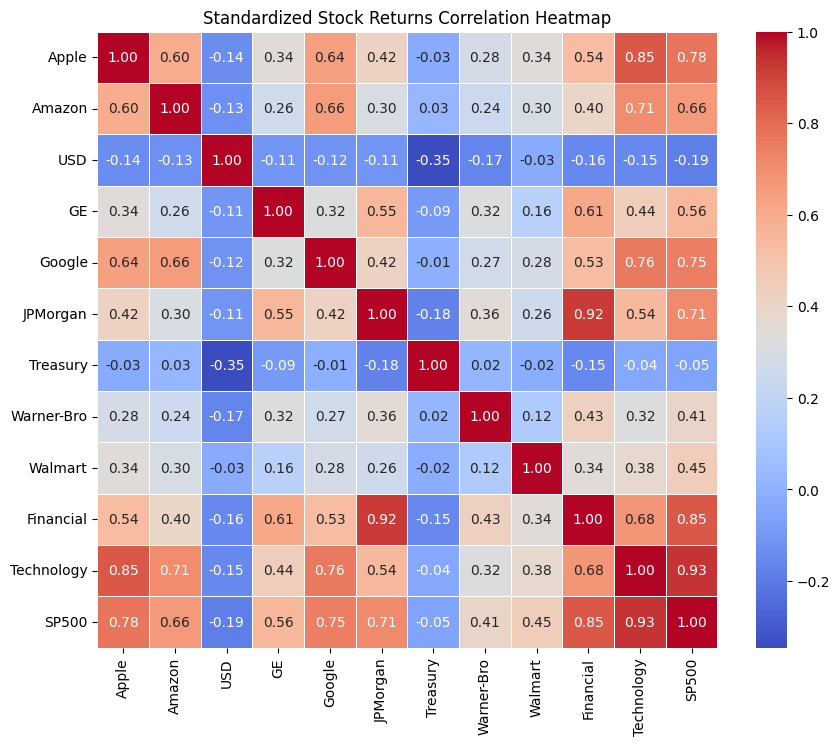

In [20]:
corr_matrix = standardized_returns.corr()
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Standardized Stock Returns Correlation Heatmap')
plt.show()

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca.fit(standardized_returns)

pr_var = pca.explained_variance_ratio_
cum_pr = np.cumsum(pr_var)
ind = ["Proportion of variance", "Cumulative proportion of variance"]
cols = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12"]
pd.DataFrame(np.vstack((pr_var, cum_pr)), ind, columns=cols)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Proportion of variance,0.473912,0.119811,0.104756,0.069253,0.060848,0.050367,0.041749,0.034372,0.026717,0.011765,0.004958,0.001493
Cumulative proportion of variance,0.473912,0.593723,0.698479,0.767733,0.828581,0.878947,0.920696,0.955067,0.981784,0.993549,0.998507,1.000000


In [22]:
# Coefficients (Loadings) of 11 Principal Components
pc_res = pd.DataFrame(pca.components_.T, index=list(standardized_returns.columns), columns=cols)
pc_res

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Apple,0.336618,0.156114,0.229823,-0.108927,-0.020074,-0.051818,0.016416,0.685026,-0.157630,-0.529634,0.137296,0.028367
Amazon,0.293807,0.257705,0.302293,-0.199293,0.069379,0.012017,0.200797,-0.586978,-0.549002,-0.145578,0.055360,-0.026187
USD,-0.086461,-0.477992,0.501289,-0.061022,0.255489,0.626723,-0.219362,0.028576,-0.038164,0.010505,0.021095,0.005376
GE,0.255220,-0.249913,-0.321524,-0.037281,-0.198934,0.439109,0.718826,0.017102,0.101493,-0.076534,-0.043271,-0.014617
Google,0.326271,0.171345,0.233275,-0.210983,-0.030129,0.009319,-0.104345,-0.291481,0.788600,-0.212680,0.005558,-0.035506
JPMorgan,0.315332,-0.323989,-0.285074,0.100329,-0.192934,-0.017004,-0.430172,-0.163299,-0.155151,-0.341543,-0.541802,0.144096
Treasury,-0.030342,0.636880,-0.293954,0.155571,-0.007289,0.634430,-0.278131,0.021625,-0.040576,-0.021842,0.002424,-0.018531
Warner-Bro,0.197936,-0.030170,-0.374501,-0.205186,0.876365,-0.066114,0.015373,0.038104,0.030229,-0.002753,-0.050150,-0.006899
Walmart,0.191042,0.033583,0.214897,0.895467,0.247916,-0.062840,0.171798,-0.057037,0.080762,-0.071057,-0.051637,-0.043761
Financial,0.361110,-0.249889,-0.238865,0.103426,-0.124026,-0.011620,-0.292430,-0.078743,-0.069254,0.090923,0.649120,-0.444689


# L3    Granger Causality

In [24]:
standardized_returns = (returns-returns.mean())/returns.std()

In [27]:
#ADF test on JPM
jp_result = adfuller(returns['JPMorgan'])
print('p_value of JPM ADF : ',jp_result[1] )

p_value of JPM ADF :  1.0469100126870526e-22


In [28]:
#ADF test on Tech
tech_result = adfuller(returns['Technology'])
print('p_value of Tech ADF : ',tech_result[1] )

p_value of Tech ADF :  1.9317572034066948e-25


In [29]:
from statsmodels.tsa.api import VAR

gc_data = returns[['JPMorgan', 'Technology']]

model=VAR(gc_data)
lag_order_result = model.select_order(maxlags=10)
lag_order = lag_order_result.aic
print('Optimal Lag Order : ', lag_order)

/opt/anaconda3/envs/test_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal Lag Order :  9


In [30]:
model_fitted = model.fit(lag_order)

In [32]:
test_result = model_fitted.test_causality(caused='Technology', causing='JPMorgan', kind='f')
print(test_result.summary())

Granger causality F-test. H_0: JPMorgan does not Granger-cause Technology. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value          df        
---------------------------------------------------------
         2.353          1.883   0.012 (9, np.int64(3462))
---------------------------------------------------------


In [33]:
test_result = model_fitted.test_causality(caused='JPMorgan', causing='Technology', kind='f')
print(test_result.summary())

Granger causality F-test. H_0: Technology does not Granger-cause JPMorgan. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value          df        
---------------------------------------------------------
         3.105          1.883   0.001 (9, np.int64(3462))
---------------------------------------------------------


### Check stationarity for all time series 

In [35]:
results = {'Column' : [], 'P-value' : [], 'Stationary (5% level)' : []}

for column in returns.columns:
    adfresult=adfuller(returns[column])

    pvalue= adfresult[1]

    results['Column'].append(column)
    results['P-value'].append(p_value)
    results['Stationary (5% level)'].append('Yes' if p_value <0.05 else 'No')

results_df = pd.DataFrame(results)
results_df

,Column,P-value,Stationary (5% level)
0,Apple,0.002482,Yes
1,Amazon,0.002482,Yes
2,USD,0.002482,Yes
3,GE,0.002482,Yes
4,Google,0.002482,Yes
5,JPMorgan,0.002482,Yes
6,Treasury,0.002482,Yes
7,Warner-Bro,0.002482,Yes
8,Walmart,0.002482,Yes
9,Financial,0.002482,Yes


## Run a pariwise var model and granger causality network

In [37]:
n_var = len(returns.columns)
adj_matrix = np.zeros((n_var,n_var))

p_threshold = 0.05/(n_var*(n_var-1))

for i, return_i in enumerate(returns):
    for j, return_j in enumerate(returns):
        if i!=j:
            var_data = returns[[return_i,  return_j]]
            model=VAR(var_data)
            lag_order_results= model.select_order(maxlags=10)
            lag_order = lag_order_results.aic
            if lag_order >0 : 
                final_order=lag_order
            else:
                final_order=1
            model_fitted= model.fit(final_order)
            test_result = model_fitted.test_causality(caused=return_j, causing=return_i, kind='f')
            p_value = test_result.pvalue

            adj_matrix[i,j]= 1 if p_value < p_threshold else 0
    
# Create directed graph from adjacency matrix
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Relabel nodes with asset names
mapping = {i: name for i, name in enumerate(returns)}
G = nx.relabel_nodes(G, mapping)

/opt/anaconda3/envs/test_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/test_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

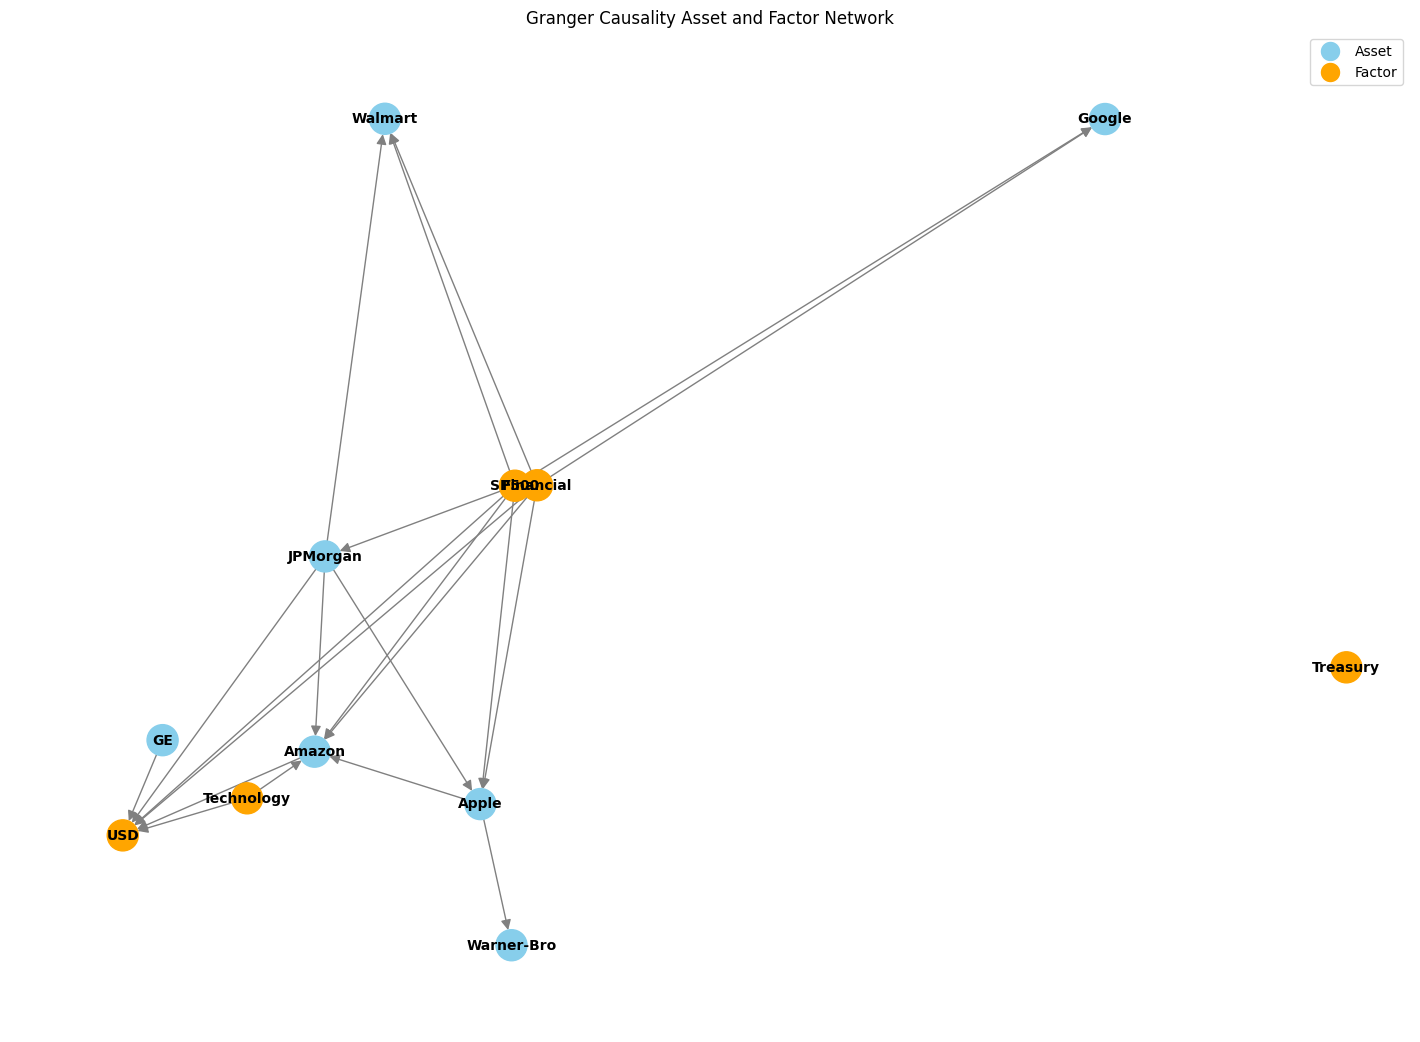

In [38]:
# Create and visualize the network

# Assign types to nodes
node_types = {
    'Apple':'Asset',
    'Amazon':'Asset',
    'USD':'Factor',
    'GE':'Asset',
    'Google':'Asset',
    'JPMorgan':'Asset',
    'Treasury':'Factor',
    'Warner-Bro':'Asset',
    'Walmart':'Asset',
    'Financial':'Factor',
    'Technology':'Factor',
    'SP500':'Factor',
}

nx.set_node_attributes(G, node_types, 'type')

# Draw the network graph
plt.figure(figsize=(14, 10))

# Use different colors for assets and factors
node_colors = ['skyblue' if G.nodes[name]['type'] == 'Asset' else 'orange' for name in G.nodes()]

# Create layout
pos = nx.spring_layout(G, seed=42)

# Draw the network
nx.draw(G, pos,
        with_labels=True,
        node_size=500,
        node_color=node_colors,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        arrows=True,
        arrowsize=15)

# Add a legend
asset_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue',
                       markersize=15, label='Asset')
factor_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange',
                        markersize=15, label='Factor')
plt.legend(handles=[asset_patch, factor_patch], loc='upper right')

plt.title('Granger Causality Asset and Factor Network')
plt.show()

In [39]:
gc_data = returns[['Amazon','SP500','USD']]

model= VAR(gc_data)
lag_order_results = model.select_order(maxlags=10)
lag_order = lag_order_results.aic
model_fitted= model.fit(lag_order)

test_result = model_fitted.test_causality(caused='USD', causing='Amazon', kind='f')
test_result.summary()

/opt/anaconda3/envs/test_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Test statistic,Critical value,p-value,df
1.673,1.882,0.090,"(9, np.int64(5166))"
